In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
task = mnist.MNIST()
task.load_all_data(device)

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
import xarray as xr
import argparse
from ga import calc_npop_truncate

In [5]:
def ackley(x):
    d = x.shape[-1]
    a = -20*torch.exp(-0.2*torch.sqrt(x.pow(2.).sum(dim=-1)/d))
    b = -torch.exp(torch.cos(2*np.pi*x).sum(dim=-1)/d)
    return a + b + np.e + 20

def fitackley(pop):
    if type(pop) is list:
        pop = torch.stack(pop)
    fitdata = xr.DataArray(np.zeros((len(pop), 2)), dims=['pop', 'metric'], 
                           coords={'metric':['fn_val', 'fitness']})
    val = ackley(pop).detach().cpu().numpy()
    fitdata[:, 0] = val
    fitdata[:, 1] = -val
    return fitdata
    
a = torch.randn(3000)
def lin_fn(x):
    d = x.shape[-1]
    return (a[:d]*x).sum(dim=-1)


optim_fn = ackley

In [13]:
device = 'cuda:3'
net = models_pheno.BigConvNet()
net = net.to(device)
def fit_mnist(pop):
    pop = pop.to(device)
    fit = task.calc_pop_fitness(pop, geno2pheno=lambda x: util.vec2model(x, net), device=device)
    return torch.from_numpy(fit.sel(metric='loss').data)
optim_fn = fit_mnist

In [14]:
util.count_params(net)

2140

In [30]:
args, args_ext = parser.parse_known_args('--dim 2140 --mr 1e-2 --n-gen 1000 --n-pop 50'.split())
pops, fitdata = run_evolution_base(args)
fitdata.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 50])

tensor(1.1832, dtype=torch.float64)


(0.0, 2.5)

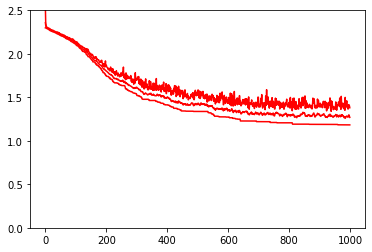

In [31]:
plt.plot(fitdata.min(dim=-1).values, c='r')
plt.plot(fitdata.mean(dim=-1), c='r')
plt.plot(fitdata.max(dim=-1).values, c='r')
print(fitdata.min())
plt.ylim(0, 2.5)

In [32]:
args, args_ext = parser.parse_known_args('--dim 2140 --mr 1e-2 --n-gen 1000 --n-pop 50'.split())
pops, fitdata, mutpops, fitdatamrs = run_evolution_mutpops(args)
fitdata.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 50])

tensor(1.2319, dtype=torch.float64)


(0.0, 2.5)

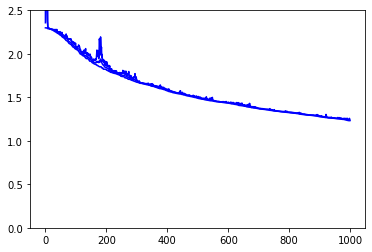

In [33]:
plt.plot(fitdata.min(dim=-1).values, c='b')
plt.plot(fitdata.mean(dim=-1), c='b')
plt.plot(fitdata.max(dim=-1).values, c='b')
print(fitdata.min())
plt.ylim(0, 2.5)

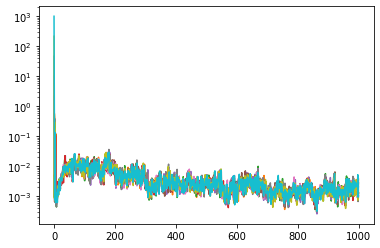

In [39]:
plt.plot(mutpops[:, :, 0]);
plt.yscale('log')

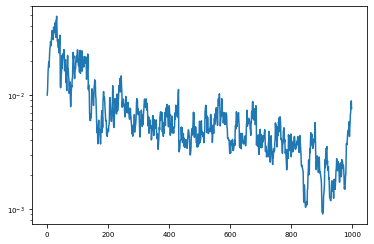

In [751]:
plt.yscale('log')
plt.plot(mutpops[:, :, 0].mean(dim=-1))

In [760]:
task.calc_pheno_fitness(util.vec2model(pops[-1, 0,:], net), device=device)

{'fitness': -0.8513119220733643, 'loss': 0.8513119220733643, 'accuracy': 73.64}

In [763]:
fitdata.min()

tensor(0.8290, dtype=torch.float64)

In [9]:
def calc_npop_truncate(pop, fit, k, k_elite=1, cross_fn=None, mutate_fn=None, clone_fn=lambda x: x):
    npop = []
    idxs_sort = np.argsort(fit)[::-1]
    idxs_elite = idxs_sort[:k_elite]
    idxs_bum = idxs_sort[:k]
    
    pop_elite = [pop[i] for i in idxs_elite]
    pop_bum = [pop[i] for i in idxs_bum]
    npop.extend([clone_fn(geno) for geno in pop_elite])
    
    n_children = len(pop)-len(npop)
    
    parents1, parents2 = np.random.choice(pop_bum, size=(2, n_children))
    if cross_fn is not None:
        children = [cross_fn(p1, p2) for p1, p2 in zip(parents1, parents2)]
    else:
        children = parents1
    children = [mutate_fn(geno) for geno in children]
    npop.extend(children)
    return util.to_np_obj_array(npop)

def calc_npop_truncate_pytorch(pop, fit, k, k_elite=1, mr=1e-2, mul_mr=False):
    npop = torch.zeros_like(pop)
    idxs_sort = torch.argsort(fit)
    idxs_elite = idxs_sort[:k_elite]
    idxs_bum = idxs_sort[:k]
    
    pop_elite = pop[idxs_elite]
    pop_bum = pop[idxs_bum]
    npop[:k_elite] = pop_elite
    
    n_children = len(pop)-k_elite
    
    idxs = np.random.choice(len(pop_bum), size=(n_children, ), replace=True)
    if mul_mr:
        eps = -1+2*torch.rand(n_children, len(pop[0]), device=pop.device, dtype=pop.dtype)
        eps = mr**eps
        children = pop_bum[idxs]*eps
    else:
        eps = mr*torch.randn(n_children, len(pop[0]), device=pop.device, dtype=pop.dtype)
        children = pop_bum[idxs]+eps
    npop[k_elite:] = children
    return npop

def calc_npop_ns(pop, mutpop, fit, k, k_elite=1, mr_mut=2.):
    npop = torch.zeros_like(pop)
    nmutpop = torch.zeros_like(mutpop)
    
    idxs_sort = torch.argsort(fit)
    idxs_elite = idxs_sort[:k_elite]
    idxs_bum = idxs_sort[:k]
    
    pop_bum = pop[idxs_bum]
    mutpop_bum = mutpop[idxs_bum]
    npop[:k_elite] = pop[idxs_elite]
    nmutpop[:k_elite] = mutpop[idxs_elite]
    
    n_children = len(pop)-k_elite
    
    idxs = np.random.choice(len(pop_bum), size=(n_children, ), replace=True)
    
    eps = mutpop_bum[idxs]*torch.randn(n_children, len(pop[0]), device=pop.device, dtype=pop.dtype)
    npop[k_elite:] = pop_bum[idxs]+eps
    
    eps = -1+2*torch.rand(n_children, len(mutpop[0]), device=mutpop.device, dtype=mutpop.dtype)
    eps = mr_mut**eps
    nmutpop[k_elite:] = mutpop_bum[idxs]*eps
    return npop, nmutpop



In [10]:
def get_mrs_fitness(x, mrs, n_samples=None):
    for _ in range(x.ndim):
        mrs = mrs[..., None]
    shape = list(x.shape)
    if n_samples is not None:
        shape = [n_samples] + shape
        mrs = mrs[..., None]
    xmut = x+torch.randn(shape)*mrs
    fit_diff = optim_fn(xmut) - optim_fn(x)
    return fit_diff

In [17]:
parser = argparse.ArgumentParser(description='Run ackley.')
parser.add_argument('--dim', type=int, default=100)
parser.add_argument('--n-pop', type=int, default=100)
parser.add_argument('--n-mutpop', type=int, default=10)
parser.add_argument('--n-gen', type=int, default=1000)
parser.add_argument('--mr', type=float, default=1e-2)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--device', type=str, default='cpu')

def run_evolution_base(args):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    pop = torch.randn(args.n_pop, args.dim, device=args.device)/6.
    fitdata, pops = [], []
    for i in tqdm(range(args.n_gen)):
        fitdata.append(optim_fn(pop))
        pops.append(pop)
        pop = calc_npop_truncate_pytorch(pop, fitdata[-1], k=len(pop)//2, mr=args.mr)
    return torch.stack(pops), torch.stack(fitdata)
    
def run_evolution_mutpops(args):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    pop = torch.randn(args.n_pop, args.dim, device=args.device)/6.
    logmr = np.log10(args.mr)
    mutpop = torch.logspace(-3, 3, args.n_mutpop, device=args.device)[:, None]
    
    mut_assignment = np.arange(len(pop))//int(len(pop)/len(mutpop))
    fitdata, pops, mutpops, fitdatamrs = [], [], [], []
    for i in tqdm(range(args.n_gen)):
        fitdata.append(optim_fn(pop))
        pops.append(pop)
        mutpops.append(mutpop)
        
        mrs = mutpop[mut_assignment]
        fit_before = optim_fn(pop)
        fit_after = optim_fn(pop+mrs*torch.randn_like(pop))
        fit_mrs = fit_after-fit_before
        fit_mrs = fit_mrs.reshape(len(mutpop), -1)
        fitdatamrs.append(fit_mrs)
#         fit_mrs = fit_mrs.min(dim=-1).values
        fit_mrs = fit_mrs.sort(dim=-1).values[:, :1].mean(dim=-1)
        
        mutpop = calc_npop_truncate_pytorch(mutpop, fit_mrs, k=len(mutpop)//2, mr=1.4, mul_mr=True)
        pop = calc_npop_truncate_pytorch(pop, fitdata[-1], k=len(pop)//2,
                                         k_elite=1, mr=mrs[1:])
    return torch.stack(pops), torch.stack(fitdata), torch.stack(mutpops), torch.stack(fitdatamrs)

def run_evolution_ns(args):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    pop = torch.randn(args.n_pop, args.dim, device=args.device)*5.+5.
    logmr = np.log10(args.mr)
    mutpop = torch.logspace(logmr, logmr, args.n_pop, device=args.device)[:, None]
    
    fitdata, pops, mutpops = [], [], []
    for i in range(args.n_gen):
        fitdata.append(optim_fn(pop))
        pops.append(pop)
        mutpops.append(mutpop)
        
        pop, mutpop = calc_npop_ns(pop, mutpop, fitdata[-1], k=len(pop)//2, k_elite=1, mr_mut=1.4)
        
    return torch.stack(pops), torch.stack(fitdata), torch.stack(mutpops)

import cma
def run_evolution_cmaes(args):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    es = cma.CMAEvolutionStrategy(torch.randn(args.dim).tolist(), args.mr)
    #     es.disp()
    # cma.plot()  # shortcut for es.logger.plot()
    fitdata, pops, mutpops = [], [], []
    for i in tqdm(range(args.n_gen)):
        solutions = es.ask()
        pop = torch.from_numpy(np.stack(solutions))
        fit = optim_fn(pop)
        es.tell(solutions, fit.tolist())
        fitdata.append(fit)
        pops.append(pop)
        
        
    return torch.stack(pops), torch.stack(fitdata)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

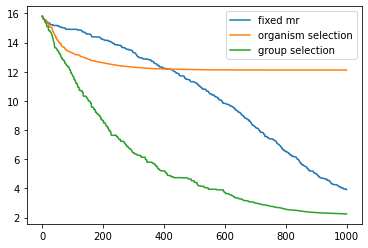

In [323]:
args, args_ext = parser.parse_known_args('--dim 100 --mr 1e-1 --n-gen 1000'.split())
pops1, fitdata1 = run_evolution_base(args)
plt.plot(fitdata1.min(dim=-1).values, label='fixed mr')
pops1, fitdata1, mutpops1 = run_evolution_ns(args)
plt.plot(fitdata1.min(dim=-1).values, label='organism selection')

# pops, fitdata = run_evolution_cmaes(args)
# plt.plot(fitdata1.min(dim=-1).values)
pops, fitdata, mutpops, fitdatamrs = run_evolution_mutpops(args)
plt.plot(fitdata.min(dim=-1).values, label='group selection')
# plt.plot(fitdata.mean(dim=-1))
# plt.plot(fitdata.max(dim=-1).values)
plt.legend()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

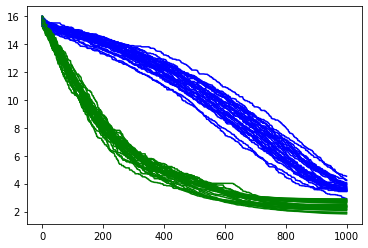

In [339]:
for seed in tqdm(range(30)):
    args, args_ext = parser.parse_known_args(f'--dim 100 --mr 1e-1 --n-gen 1000 --seed {seed}'.split())
    pops1, fitdata1 = run_evolution_base(args)
    plt.plot(fitdata1.min(dim=-1).values, c='b')
    pops, fitdata, mutpops, fitdatamrs = run_evolution_mutpops(args)
    plt.plot(fitdata.min(dim=-1).values, c='g')

In [139]:
mrs = torch.logspace(-5, 3, 32)
fit_mrs = get_mrs_fitness(pops, mrs)
best_mrs = mrs[fit_mrs.min(dim=-1).values.argmin(dim=0)]

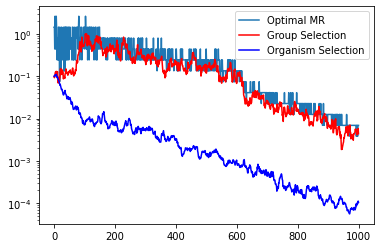

In [140]:
plt.plot(best_mrs, label='Optimal MR')
plt.plot(mutpops[:, :, 0].mean(dim=-1), 'r', label='Group Selection');
plt.plot(mutpops1[:, :, 0].mean(dim=-1), 'b', label='Organism Selection');
# plt.plot(mrs[(fit_mrs>0).sum(dim=-1).argmax(dim=0)])
plt.legend()
plt.yscale('log')

In [380]:
pop = torch.randn(101, 300)*100
fit = torch.randn(101)
mrs = torch.logspace(-8, -1, 100)[:, None]
npop, idxs = calc_npop_truncate_pytorch_full(pop, fit, k=50, k_elite=1, mr=mrs)

In [445]:
def calc_npop_truncate_pytorch_full(pop, fit, k, k_elite=1, mr=1e-2, mul_mr=False):
    npop = torch.zeros_like(pop)
    idxs_sort = torch.argsort(fit)
    idxs_elite = idxs_sort[:k_elite]
    idxs_bum = idxs_sort[:k]
    
    pop_bum = pop[idxs_bum]
    npop[:k_elite] = pop[idxs_elite]
    
    n_children = len(pop)-k_elite
    
    idxs = np.random.choice(len(idxs_bum), size=(n_children, ), replace=True)
    idxs = idxs_bum[idxs]
    if mul_mr:
        eps = -1+2*torch.rand(n_children, len(pop[0]), device=pop.device, dtype=pop.dtype)
        eps = mr**eps
        children = pop[idxs]*eps
    else:
        children = pop[idxs]+mr*torch.randn_like(pop[idxs])
    npop[k_elite:] = children
    
    return npop, idxs

def run_evolution_mutpops_full(args):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    pop = torch.randn(args.n_pop+1, args.dim, device=args.device)*5+5.
    logmr = np.log10(args.mr)
    mutpop = torch.logspace(-3, 3, args.n_mutpop, device=args.device)[:, None]
    
    k_elite = 1
    mut_assignment = np.arange(len(pop)-k_elite)//int(len(pop)/len(mutpop))
    
    fitdata, pops, mutpops, fitdatamrs = [], [], [], []
    idxss = []
    stuff = []
    for i in range(args.n_gen):
        fitdata.append(optim_fn(pop))
        pops.append(pop)
        mutpops.append(mutpop)
        
        mrs = mutpop[mut_assignment]
        bpop = pop
        pop, idxs = calc_npop_truncate_pytorch_full(pop, fitdata[-1], k=len(pop)//2,
                                         k_elite=1, mr=mrs)
        idxss.append(idxs)
#         stuff.append((bpop[idxs], pop[k_elite:]))
#         stuff.append((ackley(bpop[idxs]), ackley(pop[k_elite:])))
#         stuff.append((fitdata[-1][idxss[-1]], ackley(pop[k_elite:])))
        fit_before = fitdata[-1][idxs]
        if i>20:
            stuff.append((fitdata[-2][idxss[-2]], ackley(pops[-1][k_elite:])))
            fit_after = fitdata[-1][k_elite:]
            
            
#             fit_before = fitdata[-1][k_elite:]
#             fit_after = optim_fn(pop[k_elite:]+mrs*torch.randn_like(pop[k_elite:]))
#             fit_before = optim_fn(pops[-10][k_elite:])
#             fit_after = optim_fn(pops[-10][k_elite:]+mrs*torch.randn_like(pops[-3][k_elite:]))
#             fit_before = fitdata[-2][idxss[-2]]
#             fit_after = fitdata[-1][k_elite:]


#             fit_before = fitdata[-2][idxss[-2]]
            p, p2 = stuff[-1]
            fit_before = p
#             fit_after = fitdata[-1][k_elite:]
#             fit_after = optim_fn(p+mrs*torch.randn_like(p))
            fit_after = p2
            
            fit_mrs = fit_after-fit_before
            fit_mrs = fit_mrs.reshape(len(mutpop), -1)
            fitdatamrs.append(fit_mrs)
            fit_mrs = fit_mrs.min(dim=-1).values
#             fit_mrs = fit_mrs.sort(dim=-1).values[:, :1].mean(dim=-1)
            
            mutpop = calc_npop_truncate_pytorch(mutpops[-2], fit_mrs, k=len(mutpop)//2, mr=1.4, mul_mr=True)
    return torch.stack(pops), torch.stack(fitdata), torch.stack(mutpops), torch.stack(fitdatamrs)

def run_evolution_mutpops_full(args):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    pop = torch.randn(args.n_pop+1, args.dim, device=args.device)*5+5.
    logmr = np.log10(args.mr)
    mutpop = torch.logspace(-3, 3, args.n_mutpop, device=args.device)[:, None]
    
    k_elite = 1
    mut_assignment = np.arange(len(pop)-k_elite)//int(len(pop)/len(mutpop))
    
    fitdata, pops, mutpops, fitdatamrs = [], [], [], []
    
    fit = optim_fn(pop)
    for i in range(args.n_gen):
        bpop = pop
        bfit = fit
        bmutpop = mutpop
        
        mrs = mutpop[mut_assignment]
        pop, idxs = calc_npop_truncate_pytorch_full(pop, fit, k=len(pop)//2,
                                         k_elite=1, mr=mrs)
        fit = optim_fn(pop)
        
        fit_mrs = fit[k_elite:]-bfit[idxs]
        fit_mrs = fit_mrs.reshape(len(mutpop), -1)
        fitdatamrs.append(fit_mrs)
        fit_mrs = fit_mrs.min(dim=-1).values

        mutpop = calc_npop_truncate_pytorch(mutpop, fit_mrs, k=len(mutpop)//2, mr=1.4, mul_mr=True)
        
        fitdata.append(fit)
        pops.append(pop)
        mutpops.append(mutpop)
    return torch.stack(pops), torch.stack(fitdata), torch.stack(mutpops), torch.stack(fitdatamrs)

  0%|          | 0/5 [00:00<?, ?it/s]

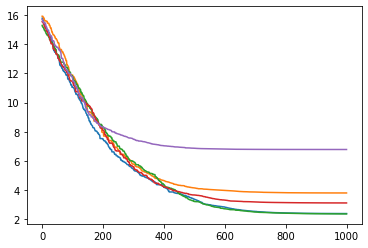

In [446]:
for seed in tqdm(range(5)):
    args, args_ext = parser.parse_known_args(f'--dim 100 --mr 1e-1 --n-gen 1000 --seed {seed}'.split())
    pops, fitdata, mutpops, fitdatamrs = run_evolution_mutpops_full(args)
    plt.plot(fitdata.min(dim=-1).values)

In [32]:
def do_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [224]:
def calc_npop_truncate(pop, fit, k=.5, k_elite=None, mr=1e-2, mul_mr=False, idxs=None):
    k = int(len(pop)*k)
    if k_elite is None:
        k_elite = 1
    else:
        k_elite = int(len(pop)*k_elite)
    
    npop = torch.zeros_like(pop)
    idxs_sort = torch.argsort(fit)
    idxs_elite = idxs_sort[:k_elite]
    idxs_bum = idxs_sort[:k]
    
    npop[:k_elite] = pop[idxs_elite]
    
    n_children = len(pop)-k_elite
    
    if idxs is None:
        idxs = np.random.choice(len(idxs_bum), size=(n_children, ), replace=True)
        idxs = idxs_bum[idxs]
        
    if mul_mr:
        eps = -1+2*torch.rand(n_children, pop.shape[-1], 
                              device=pop.device, dtype=pop.dtype)
        eps = mr**eps
        children = pop[idxs]*eps
    else:
        children = pop[idxs]+mr*torch.randn_like(pop[idxs])
    npop[k_elite:] = children
    
    return npop, idxs

def calc_npop_ns(pop, mutpop, fit, k=.5, k_elite=None, mr_mut=2.):
    k = int(len(pop)*k)
    if k_elite is None:
        k_elite = 1
    else:
        k_elite = int(len(pop)*k_elite)
    
    npop = torch.zeros_like(pop)
    nmutpop = torch.zeros_like(mutpop)
    
    idxs_sort = torch.argsort(fit)
    idxs_elite = idxs_sort[:k_elite]
    idxs_bum = idxs_sort[:k]
    
    npop[:k_elite] = pop[idxs_elite]
    nmutpop[:k_elite] = mutpop[idxs_elite]
    
    n_children = len(pop)-k_elite
    
    idxs = np.random.choice(len(idxs_bum), size=(n_children, ), replace=True)
    idxs = idxs_bum[idxs]
    
    eps = mutpop[idxs]*torch.randn(n_children, pop.shape[-1], 
                                       device=pop.device, dtype=pop.dtype)
    npop[k_elite:] = pop[idxs]+eps
    
    eps = -1+2*torch.rand(n_children, mutpop.shape[-1], 
                          device=mutpop.device, dtype=mutpop.dtype)
    eps = mr_mut**eps
    nmutpop[k_elite:] = mutpop[idxs]*eps
    return npop, nmutpop


  0%|          | 0/50 [00:00<?, ?it/s]

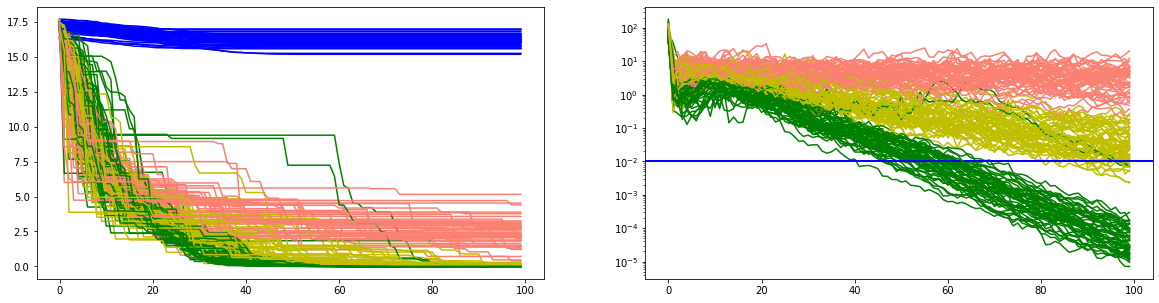

In [237]:
def run_evolution_base(pop, optim_fn, n_gen, mr, tqdm=None):
    data = []
    loop = range(n_gen)
    if tqdm is not None: loop = tqdm(loop)
    for i in loop:
        fit = optim_fn(pop)
        data.append((pop, fit))
        pop, idxs = calc_npop_truncate(pop, fit, mr=mr)
    
    pops = torch.stack([d[0] for d in data])
    fits = torch.stack([d[1] for d in data])
    return pops, fits

def run_evolution_mutpops(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., tqdm=None):
    if mr is None:
        mutpop = torch.logspace(-3, 3, n_mutpop, device=pop.device)[:, None]
    else:
        mutpop = torch.linspace(mr, mr, n_mutpop, device=pop.device)[:, None]
        
    mut_assignment = np.arange(len(pop)-1)//int(len(pop)/len(mutpop))
    data = []
    loop = range(n_gen)
    if tqdm is not None: loop = tqdm(loop)
    for i in loop:
        fit = optim_fn(pop)
        
        mrs = mutpop[mut_assignment]
        fit_b = optim_fn(pop[1:])
        fit_a = optim_fn(pop[1:]+mrs*torch.randn_like(pop[1:]))
        fit_mrs = (fit_a-fit_b).reshape(len(mutpop), -1)
        data.append((pop, fit, mutpop, fit_mrs))
        
#         fit_mrs = fit_mrs.min(dim=-1).values
        fit_mrs = fit_mrs.sort(dim=-1).values[:, :1].mean(dim=-1)
        mutpop, _ = calc_npop_truncate(mutpop, fit_mrs, mr=mr_mut, mul_mr=True)
        pop, _ = calc_npop_truncate(pop, fit, mr=mrs)
        
    pops = torch.stack([d[0] for d in data])
    fits = torch.stack([d[1] for d in data])
    mutpops = torch.stack([d[2] for d in data])
    fitmrs = torch.stack([d[3] for d in data])
    return pops, fits, mutpops, fitmrs

def run_evolution_mutpops_full(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., tqdm=None):
    if mr is None:
        mutpop = torch.logspace(-3, 3, n_mutpop, device=pop.device)[:, None]
    else:
        mutpop = torch.linspace(mr, mr, n_mutpop, device=pop.device)[:, None]
        
    mut_assignment = np.arange(len(pop)-1)//int(len(pop)/len(mutpop))
    data = []
    
    fit = optim_fn(pop)
    
    loop = range(n_gen)
    if tqdm is not None: loop = tqdm(loop)
    for i in loop:
        bpop = pop
        bfit = fit
        
        mrs = mutpop[mut_assignment]
        pop, idxs = calc_npop_truncate(pop, fit, mr=mrs)
        fit = optim_fn(pop)
        
        fit_mrs = (fit[1:]-bfit[idxs]).reshape(len(mutpop), -1)
        data.append((bpop, bfit, mutpop, fit_mrs))
        fit_mrs = fit_mrs.min(dim=-1).values
        mutpop, _ = calc_npop_truncate(mutpop, fit_mrs, mr=mr_mut, mul_mr=True)
        
        
    pops = torch.stack([d[0] for d in data])
    fits = torch.stack([d[1] for d in data])
    mutpops = torch.stack([d[2] for d in data])
    fitmrs = torch.stack([d[3] for d in data])
    return pops, fits, mutpops, fitmrs

def run_evolution_ns(pop, optim_fn, n_gen, mr=None, mr_mut=2., tqdm=None):
    if mr is None:
        mutpop = torch.logspace(-3, 3, len(pop), device=pop.device)[:, None]
    else:
        mutpop = torch.linspace(mr, mr, len(pop), device=pop.device)[:, None]
    
    data = []
    loop = range(n_gen)
    if tqdm is not None: loop = tqdm(loop)
    for i in loop:
        fit = optim_fn(pop)
        pop, mutpop = calc_npop_ns(pop, mutpop, fit, mr_mut=2.)
#         pop, idxs = calc_npop_truncate(pop, fit, mr=mutpop)
#         mutpop, idxs = calc_npop_truncate(mutpop, fit[1:], mr=mr_mut, mul_mr=True, idxs=idxs)
        data.append((pop, fit, mutpop))
        
    pops = torch.stack([d[0] for d in data])
    fits = torch.stack([d[1] for d in data])
    mutpops = torch.stack([d[2] for d in data])
    return pops, fits, mutpops

def run_evolution_cmaes(pop, optim_fn, n_gen, mr, tqdm=None):
    es = cma.CMAEvolutionStrategy(pop[0].tolist(), mr)
    data = []
    loop = range(n_gen)
    if tqdm is not None: loop = tqdm(loop)
    for i in loop:
        solutions = es.ask()
        pop = torch.from_numpy(np.stack(solutions))
        fit = optim_fn(pop)
        es.tell(solutions, fit.tolist())
        data.append((pop, fit))
        
    pops = torch.stack([d[0] for d in data])
    fits = torch.stack([d[1] for d in data])
    return pops, fits
    

fig, axs = plt.subplots(1, 2, figsize=(20,5))
for seed in tqdm(range(50)):
    do_seed(seed)
    pop = torch.randn(101, 4)*2+10.
    n_gen, mr = 100, 1e-2
    optim_fn = ackley
    pops, fits = run_evolution_base(pop, optim_fn, n_gen, mr=mr, tqdm=None)
    axs[0].plot(fits.min(dim=-1).values, c='b')
    axs[1].axhline(mr, c='b')
    mr=None
    pops, fits, mutpops = run_evolution_ns(pop, optim_fn, n_gen, mr=mr, tqdm=None)
    axs[0].plot(fits.min(dim=-1).values, c='g')
    axs[1].plot(mutpops[:, :, 0].mean(dim=-1), c='g')
    pops, fits, mutpops, fitmrs = run_evolution_mutpops(pop, optim_fn, n_gen, mr=mr, tqdm=None)
    axs[0].plot(fits.min(dim=-1).values, c='salmon')
    axs[1].plot(mutpops[:, :, 0].mean(dim=-1), c='salmon')
    pops, fits, mutpops, fitmrs = run_evolution_mutpops_full(pop, optim_fn, n_gen, mr=mr, tqdm=None)
    axs[0].plot(fits.min(dim=-1).values, c='y')
    axs[1].plot(mutpops[:, :, 0].mean(dim=-1), c='y')
    
#     pops, fits = run_evolution_cmaes(pop, ackley, n_gen, mr=mr, tqdm=None)
#     axs[0].plot(fits.min(dim=-1).values, c='orange')
axs[1].set_yscale('log')


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
for seed in tqdm(range(5)):
    do_seed(seed)
    pop = torch.randn(101, util.count_params(net))/6.
    n_gen, mr = 1000, 1e-2
    optim_fn = fit_mnist
    pops, fits = run_evolution_base(pop, optim_fn, n_gen, mr=mr, tqdm=tqdm)
    axs[0].plot(fits.min(dim=-1).values, c='b')
    axs[1].axhline(mr, c='b')
    pops, fits, mutpops = run_evolution_ns(pop, optim_fn, n_gen, mr=mr, tqdm=tqdm)
    axs[0].plot(fits.min(dim=-1).values, c='g')
    axs[1].plot(mutpops[:, :, 0].mean(dim=-1), c='g')
    pops, fits, mutpops, fitmrs = run_evolution_mutpops_full(pop, optim_fn, n_gen, mr=mr, tqdm=tqdm)
    axs[0].plot(fits.min(dim=-1).values, c='salmon')
    axs[1].plot(mutpops[:, :, 0].mean(dim=-1), c='salmon')
    
axs[1].set_yscale('log')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [76]:
def calc_npop_truncate(pop, fit, k=.5, k_elite=None, mr=1e-2, mul_mr=False, idxs=None):
    B, N, D = pop.shape
    k = int(N*k)
    if k_elite is None:
        k_elite = 1
    else:
        k_elite = int(len(pop)*k_elite)
    
    npop = torch.zeros_like(pop)
    idxs_sort = torch.argsort(fit, dim=-1)
    idxs_elite = idxs_sort[:, :k_elite]
    idxs_bum = idxs_sort[:, :k]
    
    for b in range(B):
        npop[b, :k_elite] = pop[b, idxs_elite[b]]
    
    n_children = N-k_elite
    
    if idxs is None:
        idxs = np.random.choice(k, size=(B, n_children, ), replace=True)
#         idxs = idxs_bum[:, idxs]
        idxs = torch.stack([idxs_bum[i, ii] for i, ii in enumerate(idxs)])
        
    pop_bum = torch.stack([pop[i, ii] for i, ii in enumerate(idxs)])
        
    if mul_mr:
        eps = -1+2*torch.rand(n_children, pop.shape[-1], 
                              device=pop.device, dtype=pop.dtype)
        eps = mr**eps
        children = pop[idxs]*eps
    else:
        children = pop_bum+mr*torch.randn_like(pop_bum)
    npop[:, k_elite:] = children
    
    return npop, idxs



In [84]:
%%time
pop = torch.randn(999, 100, 1000)
fit = torch.randn(999, 100)
npop, idxs = calc_npop_truncate(pop, fit)

CPU times: user 1.67 s, sys: 500 ms, total: 2.17 s
Wall time: 2.17 s


In [87]:
%%time
for i in range(999):
    pop = torch.randn(1, 100, 1000)
    fit = torch.randn(1, 100)
    npop, idxs = calc_npop_truncate(pop, fit)
    

CPU times: user 1.67 s, sys: 229 µs, total: 1.67 s
Wall time: 1.67 s


ValueError: x and y must be the same size

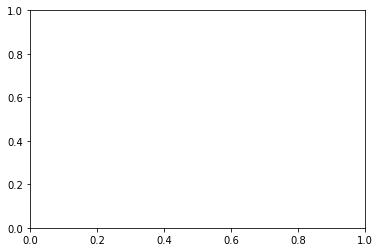

In [285]:
plt.scatter(mutpops1[:-1].repeat(1,1,10).flatten(), fitdatamrs1.flatten(), s=1)
plt.xscale('log')
plt.xlim(1e-5, 1e1);plt.ylim(-.5,.5)
plt.show()
plt.scatter(mutpops.repeat(1,1,10).flatten(), fitdatamrs.flatten(), s=1)
plt.xscale('log')
plt.xlim(1e-5, 1e1);plt.ylim(-.5,.5)
plt.show()

In [286]:
mrs = torch.logspace(-5, 3, 32)
fit_mrs = get_mrs_fitness(pops, mrs)
best_mrs = mrs[fit_mrs.min(dim=-1).values.argmin(dim=0)]
fit_mrs1 = get_mrs_fitness(pops1, mrs)
best_mrs1 = mrs[fit_mrs1.min(dim=-1).values.argmin(dim=0)]


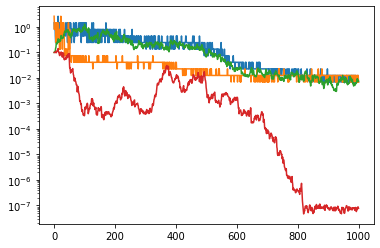

In [287]:

plt.plot(best_mrs)
plt.plot(best_mrs1)
plt.plot(mutpops[:, :, 0].mean(dim=-1));
plt.plot(mutpops1[:, :, 0].mean(dim=-1));
plt.yscale('log')
plt.show()

In [629]:
pops, fitdata, mutpops, fitdatamrs = run_evolution_mutpops(args)

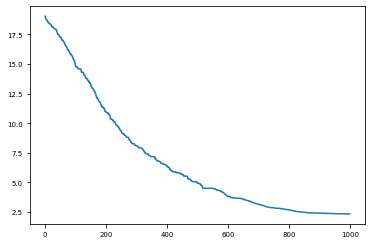

In [630]:
plt.plot(fitdata.min(dim=-1).values);

In [636]:
mutpops.shape, fitdatamrs.shape

(torch.Size([1000, 10, 1]), torch.Size([1000, 10, 10]))

In [376]:
mrs = torch.logspace(-1, 1.5, 16)
x = torch.randn(10000, 2)
fit_diff = get_mrs_fitness(x, mrs)
print(fit_diff.shape)

torch.Size([16, 10000])


In [377]:
fit_diff.min(), fit_diff.max()

(tensor(-8.3705), tensor(22.0606))

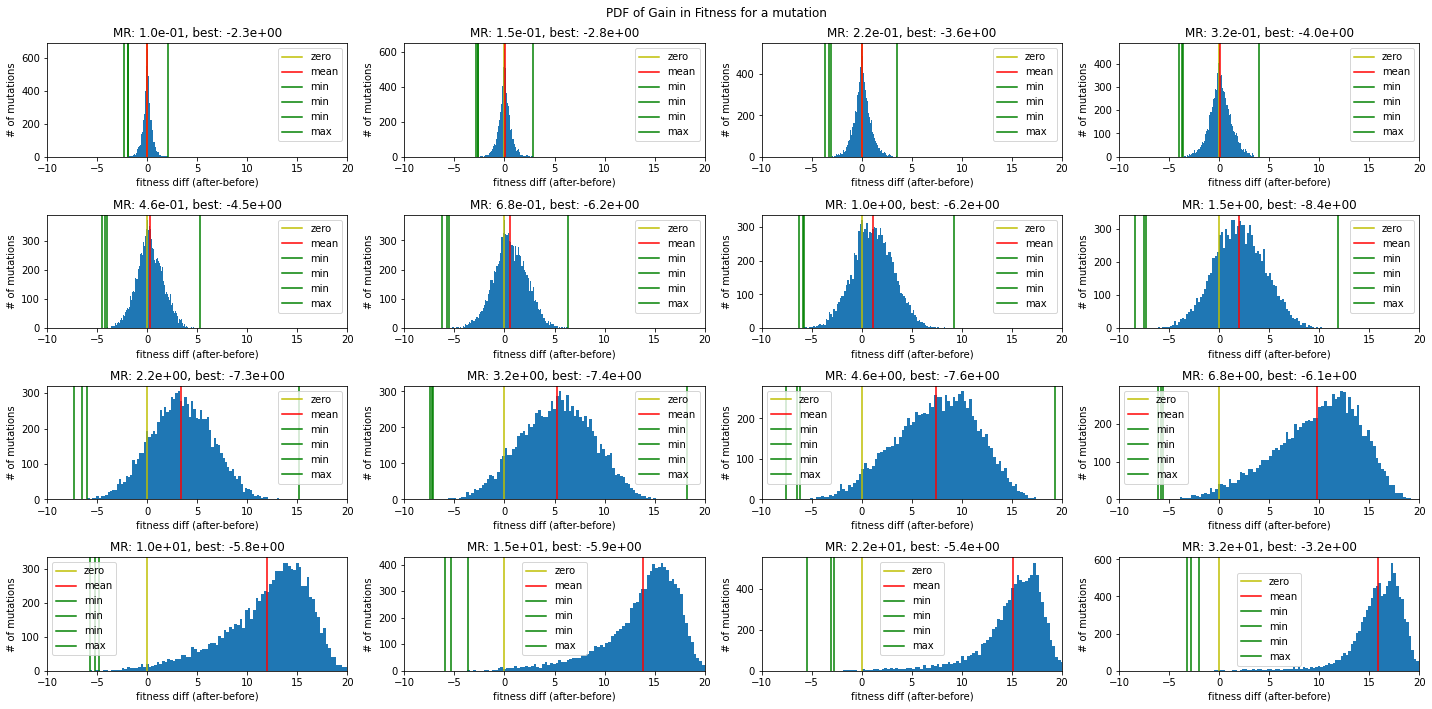

In [378]:
plt.figure(figsize=(20, 10))
for i, mr in enumerate(mrs):
    fd = fit_diff[i]
    plt.subplot(4, 4, i+1)
    plt.hist(fd.cpu().numpy(), bins=100);
    plt.axvline(c='y', label='zero')
    plt.axvline(fd.mean(), c='r', label='mean')
#     plt.axvline(fd.min(), c='g', label='min')
    for i in range(3):
        plt.axvline(np.sort(fd)[i], c='g', label='min')
    plt.axvline(fd.max(), c='g', label='max')
    plt.title(f'MR: {mr:.01e}, best: {fd.min():.01e}')
    plt.ylabel('# of mutations')
    plt.xlabel('fitness diff (after-before)')
    plt.xlim(fit_diff.min(), fit_diff.max())
    plt.xlim(-10, 20)
    plt.legend()
plt.suptitle('PDF of Gain in Fitness for a mutation')
plt.tight_layout()
plt.show()

In [379]:
mrs = torch.logspace(-1, 1.5, 100)
x = torch.randn(10000, 2)
fit_diff = get_mrs_fitness(x, mrs)
print(fit_diff.shape)

torch.Size([100, 10000])


In [380]:
# bins = np.linspace(fit_diff.min(), fit_diff.max(), 101)
bins = np.linspace(-10, 20, 101)
ns = []
for i, mr in enumerate(tqdm(mrs)):
    fd = fit_diff[i]
    n, _, chart = plt.hist(fd.cpu().numpy(), bins=bins)
    ns.append(n)
bins = np.linspace(-10, 20, 100)
ns = np.stack(ns)
plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

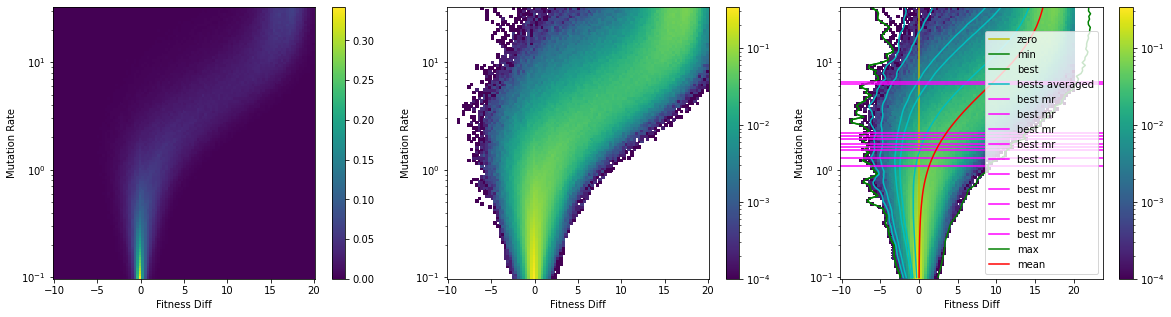

In [384]:
from matplotlib.colors import LogNorm
# def viz_mut_performance(mrs, bins, )
a, b = torch.meshgrid(torch.from_numpy(bins).float(), mrs)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.pcolormesh(a, b, ns.T/ns.sum(axis=-1), shading='auto')
plt.yscale('log')
plt.ylabel('Mutation Rate'); plt.xlabel('Fitness Diff')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(a, b, ns.T/ns.sum(axis=-1), shading='auto', norm=LogNorm())
plt.yscale('log')
plt.ylabel('Mutation Rate'); plt.xlabel('Fitness Diff')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(a, b, ns.T/ns.sum(axis=-1), shading='auto', norm=LogNorm())
plt.axvline(c='y', label='zero')
plt.plot(fit_diff.min(dim=-1).values, mrs, c='g', label='min')
for i in range(1):
    plt.plot(fit_diff.sort(dim=-1).values[:, i], mrs, c='g', 
             label='best' if i==0 else None)
for i, ii in enumerate([10, 50, 500, 1000, 5000]):
    plt.plot(fit_diff.sort(dim=-1).values[:, :ii].mean(dim=-1), mrs, c='c', 
             label='bests averaged' if i==0 else None)
for i in range(10):
    plt.axhline(best_mrs[i], c='magenta', label='best mr')
plt.plot(fit_diff.max(dim=-1).values, mrs, c='g', label='max')
plt.plot(fit_diff.mean(dim=-1), mrs, c='r', label='mean')
plt.yscale('log')
plt.ylabel('Mutation Rate'); plt.xlabel('Fitness Diff')
plt.legend()
plt.colorbar()
plt.show()

In [306]:
a = fit_diff[::10, ::1000]

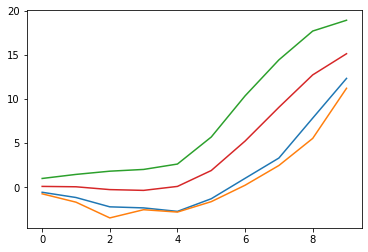

In [307]:
plt.plot(a.sort(dim=-1).values[:, :2].mean(dim=-1))
plt.plot(a.min(dim=-1).values)
plt.plot(a.max(dim=-1).values)
plt.plot(a.mean(dim=-1))


Text(0, 0.5, 'Fitness')

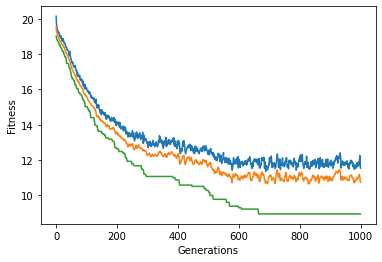

In [14]:
args, args_ext = parser.parse_known_args('--dim 100 --mr 1e-0 --n-gen 1000'.split())
pops, fitdata = run_evolution(args)

plt.plot(fitdata.max(dim=-1).values)
plt.plot(fitdata.mean(dim=-1))
plt.plot(fitdata.min(dim=-1).values)
plt.xlabel('Generations')
plt.ylabel('Fitness')

In [15]:
x = pops[::40, 0, :]
x.shape

torch.Size([25, 100])

In [16]:
mrs = torch.logspace(-4, 4, 40)
eps = mrs[:, None, None, None]*torch.randn(999, 25, 100)

In [17]:
eps.shape, x.shape

(torch.Size([40, 999, 25, 100]), torch.Size([25, 100]))

In [18]:
x = ackley(eps+x) - ackley(x)

In [19]:
x.shape # mr, samples, generations

torch.Size([40, 999, 25])

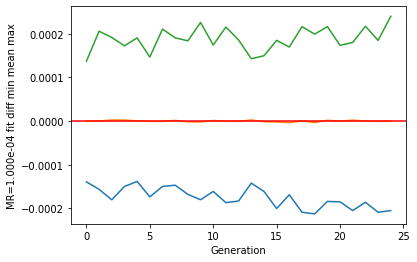

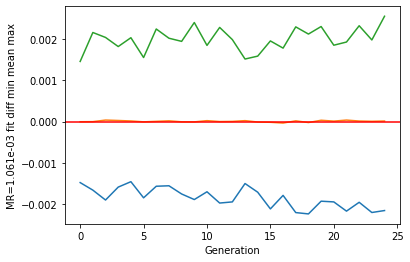

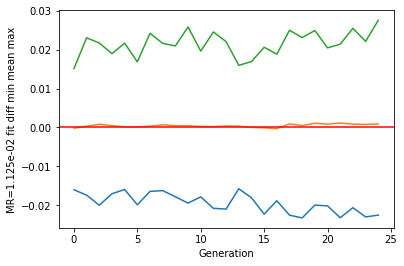

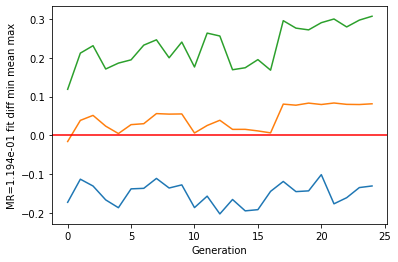

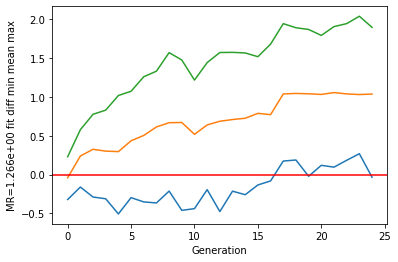

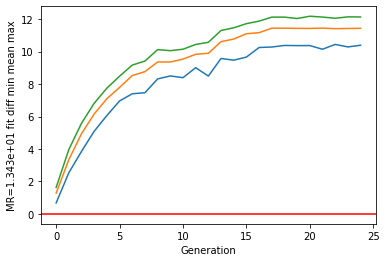

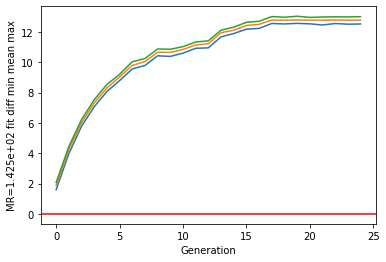

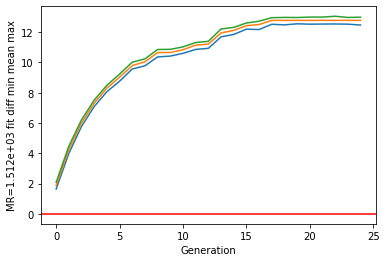

In [20]:
for i in range(0, 40, 5):
    mr = mrs[i]
    plt.plot(x.min(dim=1).values[i]);
    plt.plot(x.mean(dim=1)[i]);
    plt.axhline(c='r')
    plt.plot(x.max(dim=1).values[i]);
    plt.ylabel(f'MR={mr:.03e} fit diff min mean max')
    plt.xlabel('Generation')
    plt.show()

Text(0.5, 1.0, 'Percentage of successful mutations - MR vs Generation')

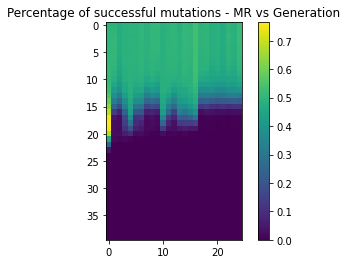

In [21]:
plt.imshow((x<0).sum(dim=1).numpy()/999)
plt.colorbar()
plt.title('Percentage of successful mutations - MR vs Generation')

Text(0.5, 1.0, 'Best sampled difference - MR vs Generation')

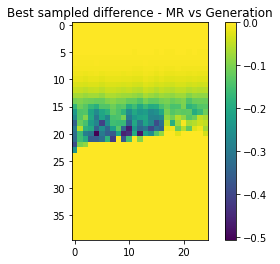

In [22]:
a = x.min(dim=1).values.numpy()
a[a>0]=0
plt.imshow(a)
plt.colorbar()
plt.title('Best sampled difference - MR vs Generation')

Text(0.5, 1.0, 'Best sampled difference - MR vs Generation')

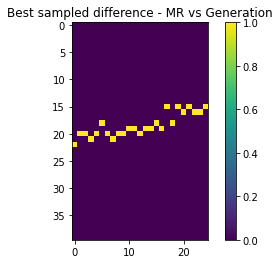

In [35]:
a = x.min(dim=1).values.numpy()
a[a>0]=0
a = (a==np.sort(a, axis=0)[0])
plt.imshow(a)
plt.colorbar()
plt.title('Best sampled difference - MR vs Generation')

In [36]:
x.shape

torch.Size([40, 999, 25])

(0.1, 10.0)

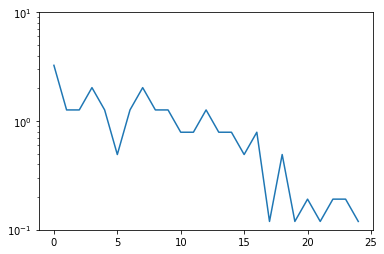

In [37]:
plt.plot(mrs[x.sort(dim=1).values[:, :1, :].mean(dim=1).argmin(dim=0)])
# plt.plot(mrs[x.min(dim=1).values.argmin(dim=0)])
plt.yscale('log')
plt.ylim(1e-1, 1e1)

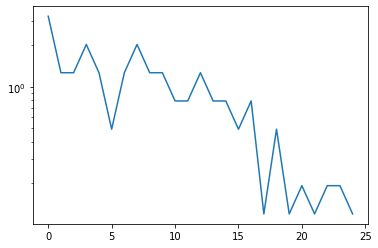

In [38]:
plt.plot(mrs[x.min(dim=1).values.min(dim=0).indices])
plt.yscale('log')

In [8]:
%%time
a = ackley(torch.randn(10000, 1000, device='cuda:3'))

CPU times: user 1.7 s, sys: 902 ms, total: 2.6 s
Wall time: 2.62 s


In [10]:
parser = argparse.ArgumentParser(description='Run ackley.')
parser.add_argument('--dim', type=int, default=100)
parser.add_argument('--n-pop', type=int, default=100)
parser.add_argument('--n-gen', type=int, default=1000)
parser.add_argument('--mr', type=float, default=1e-2)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--device', type=str, default='cpu')



CPU times: user 451 ms, sys: 32.3 ms, total: 483 ms
Wall time: 624 ms


Text(0, 0.5, 'Fitness')

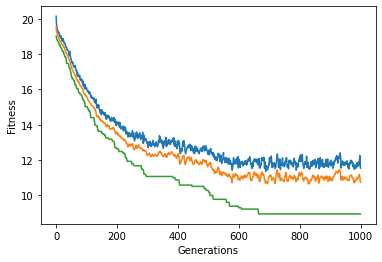

In [11]:
%%time
args, args_ext = parser.parse_known_args('--dim 100 --seed 0 --mr 1e-0'.split())
pops, fitdata = run_evolution(args)
plt.plot(fitdata.max(dim=-1).values)
plt.plot(fitdata.mean(dim=-1))
plt.plot(fitdata.min(dim=-1).values)
plt.xlabel('Generations')
plt.ylabel('Fitness')

In [12]:
seeds = np.arange(5)
mrs = np.logspace(-3, 3, num=20)
fits = np.zeros((len(seeds), len(mrs)))
for seed in tqdm(seeds):
    for mri, mr in enumerate(mrs):
        args, args_ext = parser.parse_known_args(f'--dim 100 --seed {seed} --mr {mr}'.split())
        pops, fitdata = run_evolution(args)
        fit = fitdata.min().item()
        fits[seed, mri] = fit


  0%|          | 0/5 [00:00<?, ?it/s]

0.1623776739188721
4.051939964294434


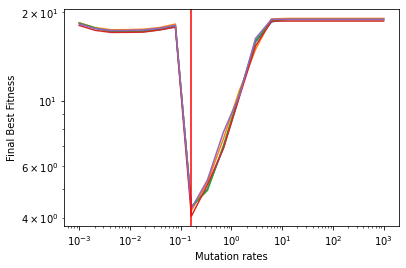

In [13]:
plt.plot(mrs, fits.T);
plt.xlabel('Mutation rates')
plt.ylabel('Final Best Fitness')
plt.xscale('log')
plt.yscale('log')
best_mr = mrs[fits.mean(axis=0).argmin()]
plt.axvline(best_mr, c='r')
print(best_mr)
print(fits.min())

In [67]:
parser = argparse.ArgumentParser(description='Run ackley.')
parser.add_argument('--dim', type=int, default=100)
parser.add_argument('--n-pop', type=int, default=100)
parser.add_argument('--n-mutpop', type=int, default=10)
parser.add_argument('--n-gen', type=int, default=1000)
parser.add_argument('--mr', type=float, default=1e-2)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--device', type=str, default='cpu')



tensor(3.0221)


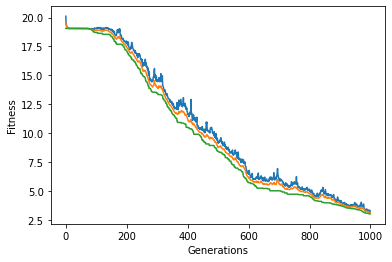

In [73]:
# %%time
args, args_ext = parser.parse_known_args('--dim 100 --seed 20 --mr 1e-3 --n-mutpop 10'.split())
pops, fitdata, mutpops, fitdatamrs = run_evolution(args)
plt.plot(fitdata.max(dim=-1).values)
plt.plot(fitdata.mean(dim=-1))
plt.plot(fitdata.min(dim=-1).values)
plt.xlabel('Generations')
plt.ylabel('Fitness')
print(fitdata.min())

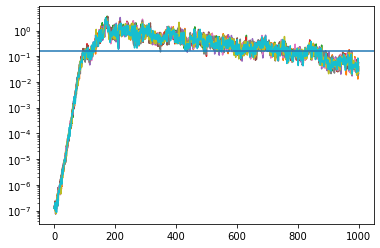

In [74]:
plt.plot(mutpops[:, :, 0].cpu().numpy());
plt.axhline(best_mr)
plt.yscale('log')

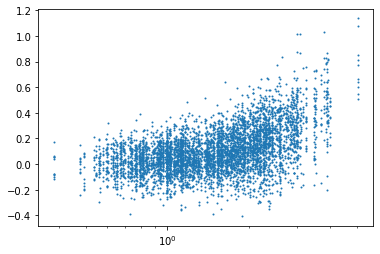

In [31]:
plt.scatter(mutpops.repeat(1,1,10).cpu()[:50].flatten().numpy(),
            fitdatamrs.cpu()[:50].flatten().numpy(), s=1.)
plt.xscale('log')

torch.Size([1000, 10, 1]) torch.Size([1000, 10, 10])


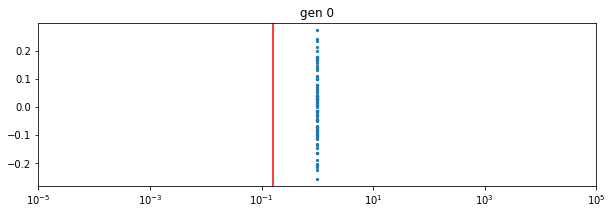

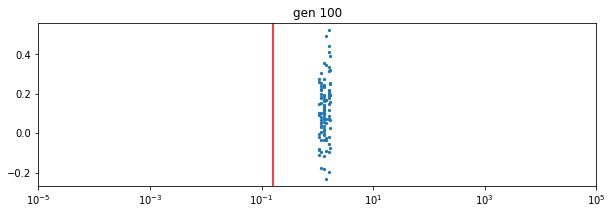

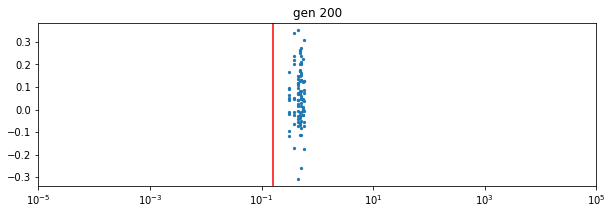

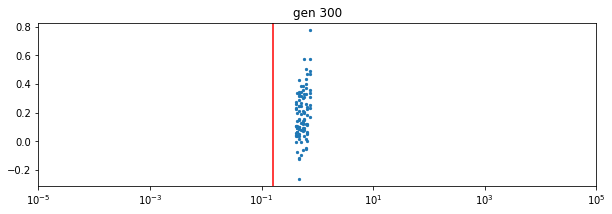

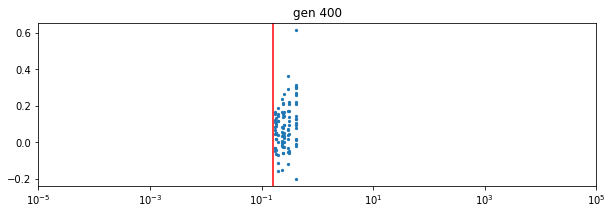

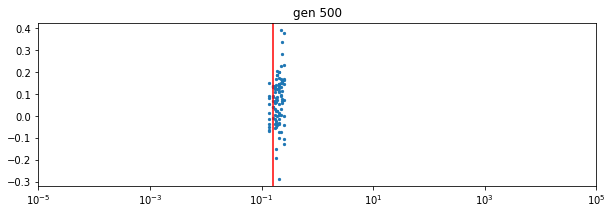

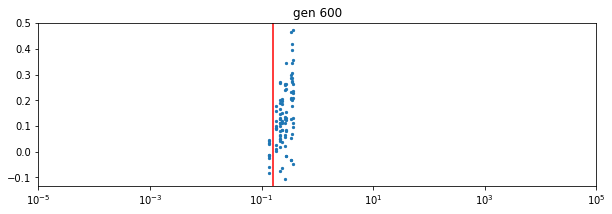

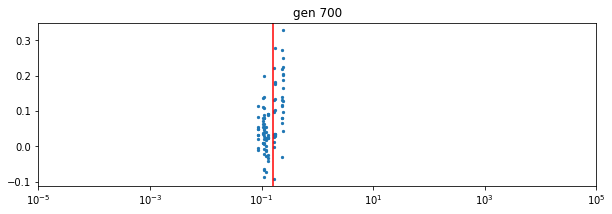

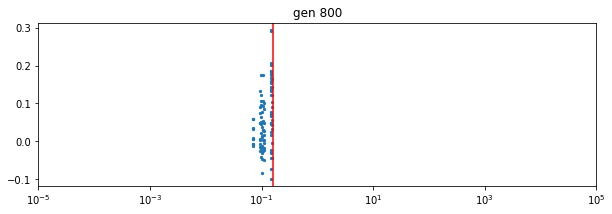

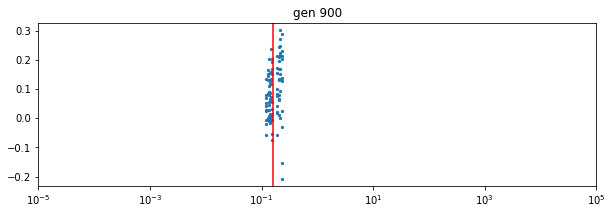

In [34]:
print(mutpops.shape, fitdatamrs.shape)
for gen_idx in range(0, 1000, 100):
    plt.figure(figsize=(10, 3))
    plt.title(f'gen {gen_idx}')
    plt.scatter(mutpops.repeat(1,1,10).cpu()[gen_idx].flatten().numpy(),
                fitdatamrs.cpu()[gen_idx].flatten().numpy(), s=5., label=f'gen {gen_idx}')
    plt.axvline(best_mr, c='r')
    plt.xscale('log')
    plt.xlim(1e-5, 1e5)
    plt.show()
    

In [67]:
parser = argparse.ArgumentParser(description='Run ackley.')
parser.add_argument('--dim', type=int, default=100)
parser.add_argument('--n-pop', type=int, default=100)
parser.add_argument('--n-gen', type=int, default=1000)
parser.add_argument('--mr', type=float, default=1e-2)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--device', type=str, default='cpu')

def run_evolution(args):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    pop = torch.randn(args.n_pop, args.dim, device=args.device)*5.+10.
    logmr = np.log(args.mr)
    mutpop = torch.logspace(logmr, logmr, args.n_pop, device=args.device)[:, None]
    
    mut_assignment = np.arange(len(pop))//int(len(pop)/len(mutpop))
    fitdata, pops, mutpops, fitdatamrs = [], [], [], []
    for i in range(args.n_gen):
        fitdata.append(fitackley(pop))
        pops.append(pop)
        mutpops.append(mutpop)
        
        mrs = mutpop[mut_assignment]
        fit_before = ackley(pop)
        fit_after = ackley(pop+mrs*torch.randn_like(pop))
        fit_mrs = fit_after-fit_before
        fit_mrs = fit_mrs.reshape(len(mutpop), -1)
        fitdatamrs.append(fit_mrs)
#         fit_mrs = fit_mrs.min(dim=-1).values
        fit_mrs = fit_mrs.sort(dim=-1).values[:, :1].mean(dim=-1)
        
        mutpop = calc_npop_truncate_pytorch(mutpop, fit_mrs, k=len(mutpop)//2, mr=1.4, mul_mr=True)
        pop = calc_npop_truncate_pytorch(pop, fitdata[-1], k=len(pop)//2,
                                         k_elite=1, mr=mrs[1:])
    return torch.stack(pops), torch.stack(fitdata), torch.stack(mutpops), torch.stack(fitdatamrs)
    

In [274]:
parser = argparse.ArgumentParser(description='Run ackley.')
parser.add_argument('--n-pop', type=int, default=100)
parser.add_argument('--n-mutpop', type=int, default=10)
parser.add_argument('--n-gen', type=int, default=50)
parser.add_argument('--eps', type=float, default=1e-2)
parser.add_argument('--meta-eps', type=float, default=2.)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--device', type=str, default='cpu')

def run_evolution(args):
    d = 100
    pop = [5+torch.randn(d).to(device)*5. for _ in range(args.n_pop)]
    mutpop = np.logspace(5, 5, args.n_mutpop)
#     mutpop = np.array([args.eps for _ in range(10)])
    fitdata, pops, mutpops = [], [], []
    loop = tqdm(range(args.n_gen), leave=False)
    for i in loop:
        fitdata.append(fitackley(pop))
        pops.append(torch.stack(pop).detach().cpu().numpy())
        mutpops.append(mutpop)
        
        mut_assignment = np.arange(len(pop))//int(len(pop)/len(mutpop))
        muts = mutpop[mut_assignment]
        
        mpop = [util.additive_noise(a, eps=m) for a, m in zip(pop, muts)]
        mutfit = fitackley(mpop)
        mutfit = (mutfit-fitdata[-1]).sel(metric='fitness').data
        mutfit = mutfit.reshape(len(mutpop), len(pop)//len(mutpop))
        print(mutpop)
        print(mutfit.min(axis=-1))
        print(mutfit.mean(axis=-1))
        print(mutfit.max(axis=-1))
        print()
        print()
        print()
        mutfit = mutfit.max(axis=-1)
        
        mutpop = calc_npop_truncate(list(mutpop), mutfit, k=int(.5*len(mutpop)), 
                                    cross_fn=lambda a, b: (a+b)/2., 
                                    mutate_fn=lambda a: a*np.random.uniform(1./args.meta_eps, 
                                                                            args.meta_eps))
        
        pop = calc_npop_truncate(pop, fitdata[-1].sel(metric='fitness').data, 
                               k=int(.5*len(pop)), cross_fn=util.uniform_crossover, 
                               mutate_fn=partial(util.additive_noise, eps=args.eps))
        pop = [i for i in pop]
        loop.set_postfix({'fitness': fitdata[-1].sel(metric='fitness').max().item()})
    fitdata = xr.concat(fitdata, dim='gen')
    pops = xr.DataArray(pops, dims=['gen', 'pop', 'weight'])
    mutpops = xr.DataArray(mutpops, dims=['gen', 'pop'])
    return fitdata, pops, mutpops

args, args_ext = parser.parse_known_args('--eps 1e-2 --meta-eps 2 --n-mutpop 4'.split())
fitdata, pops, mutpops = run_evolution(args)
print(fitdata.sel(gen=-1).mean(dim='pop').sel(metric='fn_val').data)
print(fitdata.sel(gen=-1).min(dim='pop').sel(metric='fn_val').data)

  0%|          | 0/50 [00:00<?, ?it/s]

[100000. 100000. 100000. 100000.]
[-5.53441048 -5.98071098 -5.77396965 -5.7015152 ]
[-4.73589233 -4.88808678 -4.95202072 -4.75601906]
[-4.23121834 -3.91270638 -3.76315117 -3.89758301]



[100000.0 67589.78681358916 86691.40365419061 156741.058414112]
[-5.99592018 -5.92967606 -6.12490845 -5.54571724]
[-5.11782936 -5.14691845 -5.13352386 -5.03677544]
[-4.37845039 -4.46582413 -4.43648148 -4.55459404]



[100000.0 98899.90792502112 148987.86473961928 155803.05616461235]
[-6.06178856 -6.2165041  -6.27055454 -6.84707928]
[-5.40625744 -5.33989128 -5.3249049  -5.46765812]
[-4.62432098 -4.47742653 -4.76996803 -4.79852486]



[98899.90792502112 164536.13347001004 111325.53735354936 58586.90331302274]
[-6.70987225 -6.33808517 -6.77294159 -6.67872047]
[-5.66015717 -5.74689621 -5.66784351 -5.70043945]
[-5.08821106 -5.22925377 -4.3243866  -5.02329445]



[111325.53735354936 76551.56689401127 83680.59801455606 116640.80018511355]
[-6.84273434 -6.67281914 -6.86577606 -6.95205307]
[-5.93945454 -6.09421

433331.776928984
1161582.1657143938
7102637.7644931795
97168576.6613889
12413058408.089518


Text(0.5, 0, 'Generation')

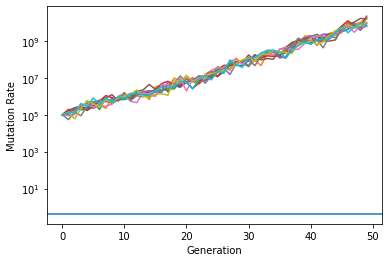

In [267]:
plt.plot(mutpops);
plt.yscale('log')
plt.axhline(.42)
print(mutpops[5].mean().data)
print(mutpops[10].mean().data)
print(mutpops[20].mean().data)
print(mutpops[30].mean().data)
print(mutpops[-1].mean().data)
plt.ylabel('Mutation Rate')
plt.xlabel('Generation')

In [248]:
a[b.argmin()]

0.4281332398719396

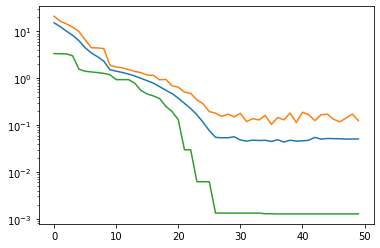

In [261]:
plt.plot(fitdata.sel(metric='fn_val').mean(dim='pop'))
plt.plot(fitdata.sel(metric='fn_val').max(dim='pop'))
plt.plot(fitdata.sel(metric='fn_val').min(dim='pop'))
plt.yscale('log')

In [114]:
a = pops[0, :, 0].data
b = pops[0, :, 1].data

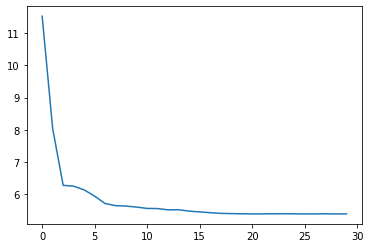

In [168]:
plt.plot(fitdata.mean('pop').sel(metric='fn_val'))

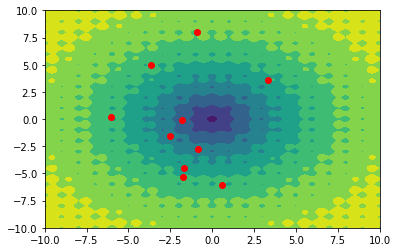

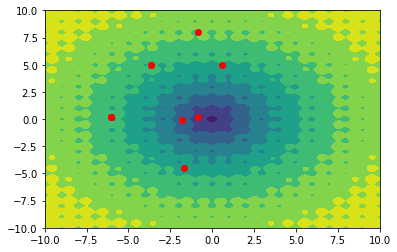

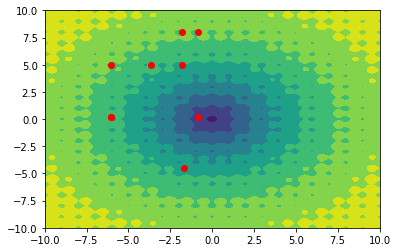

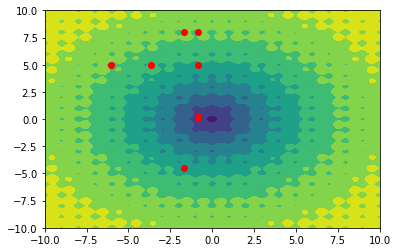

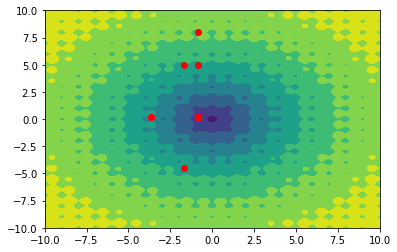

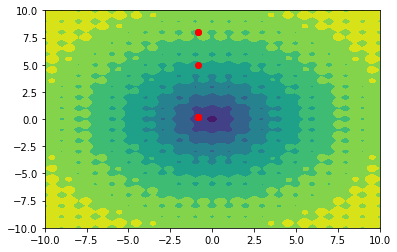

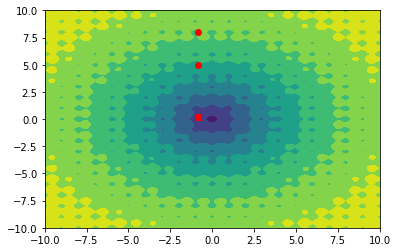

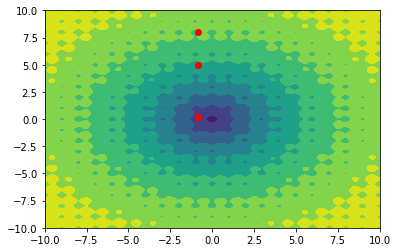

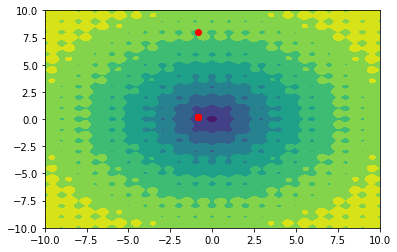

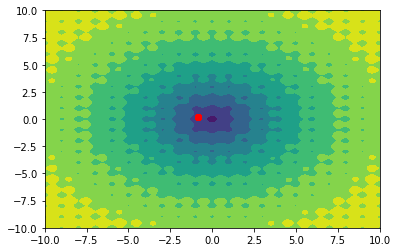

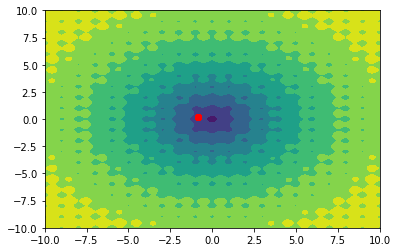

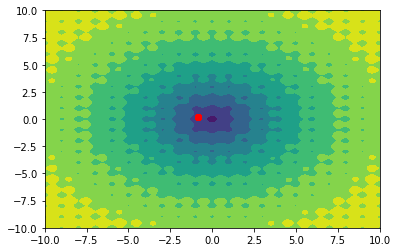

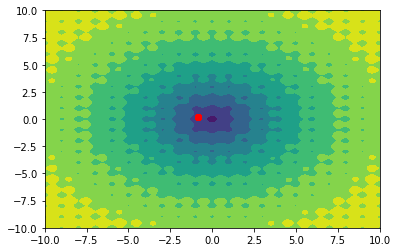

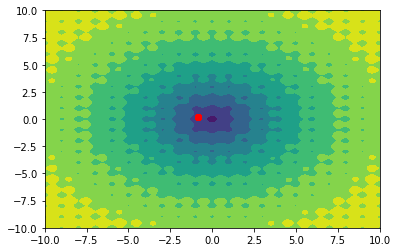

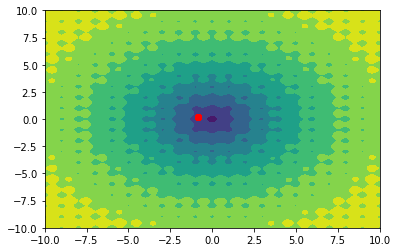

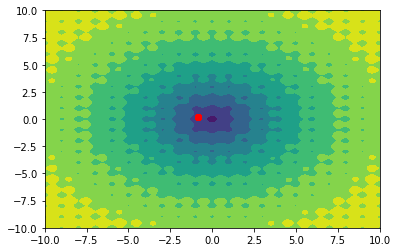

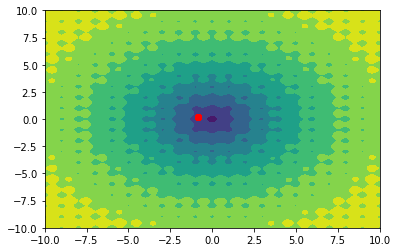

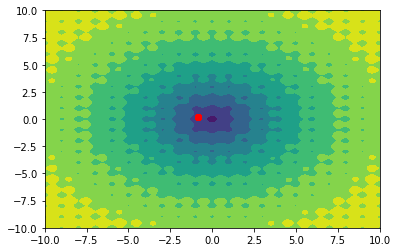

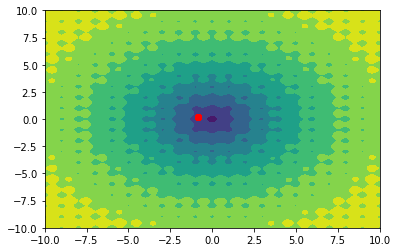

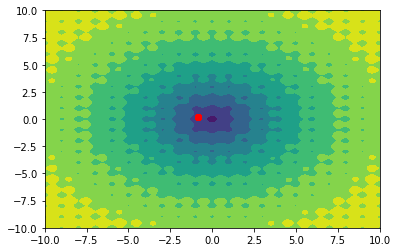

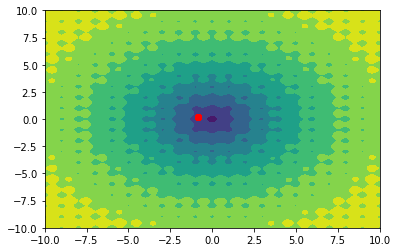

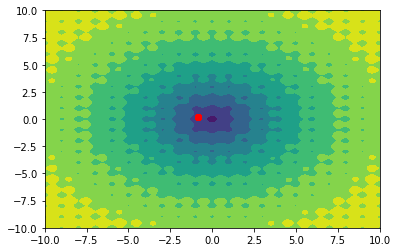

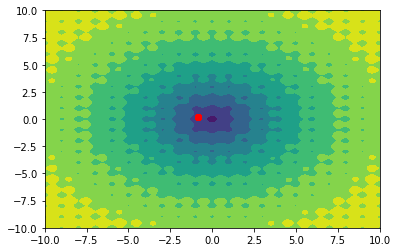

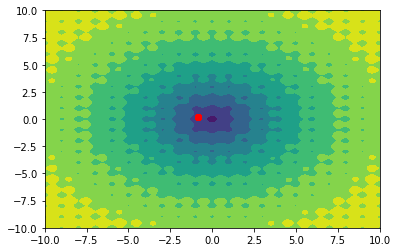

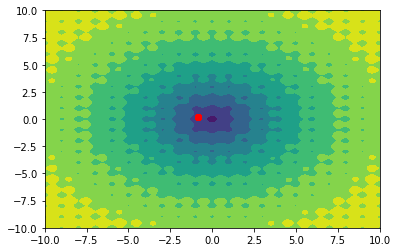

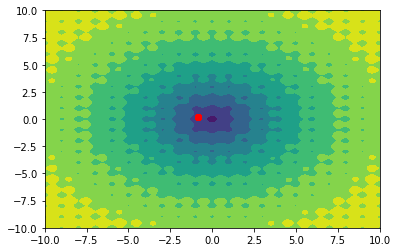

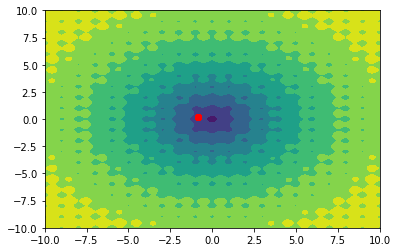

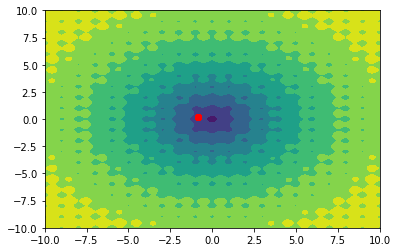

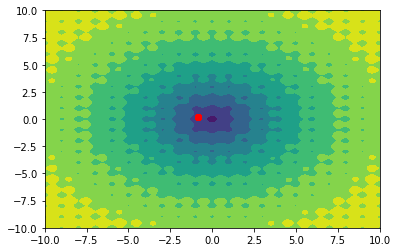

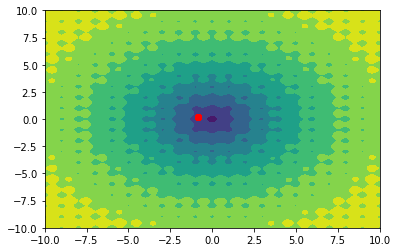

In [165]:
for i in range(len(pops)):
    plt.contourf(x1, x2, y)
    plt.scatter(pops[i, :, 0].data, pops[i, :, 1].data, c='r')
    plt.show()

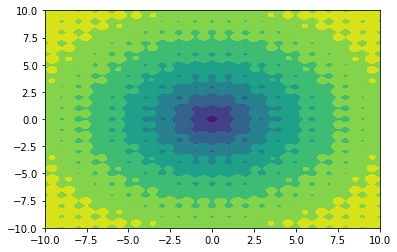

In [126]:
x1 = torch.linspace(-10, 10, 1000)
x2 = torch.linspace(-10, 10, 1000)
x1, x2 = torch.meshgrid(x1, x2)
x = torch.stack([x1, x2], dim=-1)
y = ackley(x)
plt.contourf(x1, x2, y)
# plt.imshow(y)

In [14]:
a = torch.load('data/runs/uniform_crossover.ans')
b = torch.load('data/runs/uniform_mut0.02.ans')
c = torch.load('data/runs/uniform_mut0.005.ans')

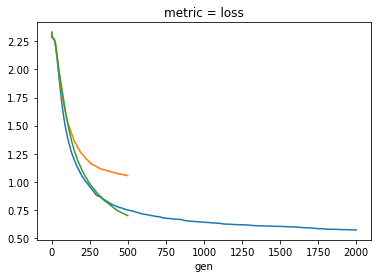

In [18]:
a.sel(metric='loss').mean(dim='seed').min(dim='pop').plot()
b.sel(metric='loss').mean(dim='seed').min(dim='pop').plot()
c.sel(metric='loss').mean(dim='seed').min(dim='pop').plot()

In [4]:
a = torch.load('data/runs/uniform_crossover.ans')
b = torch.load('data/runs/evolve_mut.ans')
c = torch.load('data/runs/evolve_mut1.ans')
d = torch.load('data/runs/no_breeder.ans')


In [170]:
np.abs((b - c[:, :150])).max()

<xarray.DataArray ()>
array(35.2)

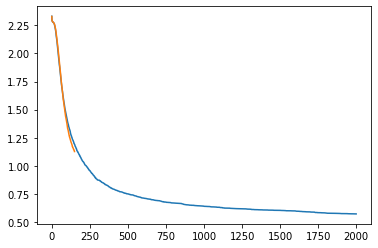

In [5]:
plt.plot(a.sel(metric='loss').mean(dim='seed').min(dim='pop'))
plt.plot(b.sel(metric='loss').mean(dim='seed').min(dim='pop'))
# plt.xlim(0, 150)

In [155]:
print(a.sel(metric='loss').mean(dim='seed').min(dim='pop').sel(gen=149).item())
print(b.sel(metric='loss').mean(dim='seed').min(dim='pop').sel(gen=149).item())


1.1923638661702474
1.1275430043538412


In [14]:
n_pop = 100
n_gens = 10
n_seeds = 3
device = 'cuda:0'
net = models_pheno.BigConvNet().to(device)
triu_mask = torch.triu(torch.ones([n_pop]*2), diagonal=1).to(bool)

def run_evolution():
    pop = [torch.randn(util.count_params(net)).to(device)/6. for _ in range(n_pop)]
    fitdata = []
    loop = tqdm(range(n_gens), leave=False)
    for i in loop:
        a = torch.stack(pop)
        cossim = torch.cosine_similarity(a[None], a[:, None], dim=-1)[triu_mask].cpu().numpy()
        l2 = (a[None]-a[:, None]).norm(dim=-1).mean()
        l2sq = (a[None]-a[:, None]).norm(dim=-1).pow(2.).mean()

        fitdata.append(task.calc_pop_fitness(pop, lambda x: util.vec2model(x, net), 
                                             n_samples=1000, device=device))

        idx_selected = np.argsort(fitdata[-1].sel(metric='fitness'))[::-1][:30].data
        pop_selected = [pop[i] for i in idx_selected]
        npop = []
        for _ in range(n_pop):
            a, b = np.random.choice(len(pop_selected), size=(2), replace=False)
            c = util.uniform_crossover(pop_selected[a], pop_selected[b], p=0.5)
            c = util.additive_noise(c, eps=1e-2)
            npop.append(c.detach())
        pop = npop


        loop.set_postfix({'loss': fitdata[-1].sel(metric='loss').min().item()})
    fitdata = xr.concat(fitdata, dim='gen')
    return fitdata
    

fitdata = []
for seed in tqdm(range(n_seeds)):
    a = run_evolution()
    fitdata.append(a)
fitdata = xr.concat(fitdata, dim='seed')



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
a = []
for i in range(15):
    a.append(torch.load(f'data/runs/{i}.ans'))
a = xr.concat(a, dim='seed')
torch.save(a, f'data/runs/uniform_mut0.005.ans')

(0.0, 10.0)

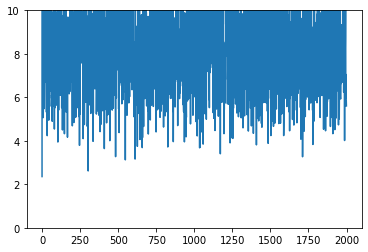

In [30]:
a = torch.load(f'data/runs/uniform_crossover.ans')
b = torch.load(f'data/runs/ConvRSBProbBreeder.ans')
c = torch.load(f'data/runs/ConvAdvancedRSBBreeder.ans')
# plt.plot(a.mean(dim='seed').mean(dim='pop').sel(metric='loss'))
# plt.plot(b.mean(dim='seed').mean(dim='pop').sel(metric='loss'))
plt.plot(c.mean(dim='seed').mean(dim='pop').sel(metric='loss'))
# for i in range(15):
#     a.mean(dim='pop').sel(metric='loss', seed=i).plot(c='r')
#     b.mean(dim='pop').sel(metric='loss', seed=i).plot(c='g')

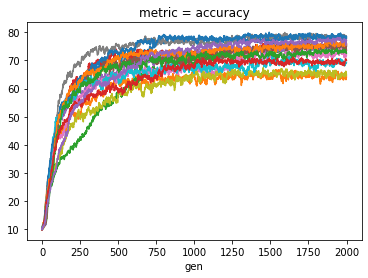

In [64]:
for seed in range(15):
    a.mean(dim='pop').sel(metric='accuracy', seed=seed).plot()

In [6]:
import os

In [9]:
print('parent process:', os.getppid(), 'process id:', os.getpid())

parent process: 9951 process id: 15005


In [21]:
import multiprocessing

In [22]:
%%time
import os
import torch
from torch.multiprocessing import Pool, Process, Manager, set_start_method
# torch.multiprocessing.set_start_method('spawn', force=True)
# torch.multiprocessing.set_start_method('forkserver', force=True)


def f(device, d):
    print('parent process:', os.getppid(), 'process id:', os.getpid())
    a = torch.randn(10).to(device)
#     for _ in range(2000):
#         a = torch.randn(1000, 10000, device=device)
#         b = torch.randn(10000, 1000, device=device)
#         c = a@b 
    print('done')
    torch.save(a, f'data/runs/temp{device}')
    
    d[device] = a.cpu()
    return a

# f('cuda:0')
# f('cuda:1')
# f('cuda:2')
# f('cuda:3')

manager = Manager()
return_dict = manager.dict()
ps = []
for i in range(4):
#     print(f'cuda:{i}')
    p = Process(target=f, args=(f'cuda:{i}', return_dict))
#     p = torch.multiprocessing.spawn(f, args=(f'cuda:{i}', ), join=True)
    p.start()
    ps.append(p) 
for p in ps:
    p.join()

parent process: 17671 process id: parent process:18373 
17671parent process:  process id:17671  parent process:18379process id:
  1839117671 process id:
 18402
done
done
done
done
CPU times: user 22.5 ms, sys: 69 ms, total: 91.5 ms
Wall time: 4.69 s


In [18]:
from collections import namedtuple

In [14]:
n_pop = 100
n_gens = 10
n_seeds = 3
device = 'cuda:0'
net = models_pheno.BigConvNet().to(device)
conet = models_breed.ConvRSBProbBreeder().to(device)
Genotype = namedtuple('Genotype', ['w', 'bw'])
triu_mask = torch.triu(torch.ones([n_pop]*2), diagonal=1).to(bool)

def run_evolution():
    pop = [torch.randn(util.count_params(net)).to(device)/6. for _ in range(n_pop)]
    fitdata = []
    loop = tqdm(range(n_gens), leave=False)
    for i in loop:
        a = torch.stack(pop)
        cossim = torch.cosine_similarity(a[None], a[:, None], dim=-1)[triu_mask].cpu().numpy()
        l2 = (a[None]-a[:, None]).norm(dim=-1).mean()
        l2sq = (a[None]-a[:, None]).norm(dim=-1).pow(2.).mean()

        fitdata.append(task.calc_pop_fitness(pop, lambda x: util.vec2model(x, net), 
                                             n_samples=1000, device=device))

        idx_selected = np.argsort(fitdata[-1].sel(metric='fitness'))[::-1][:30].data
        pop_selected = [pop[i] for i in idx_selected]
        npop = []
        for _ in range(n_pop):
            a, b = np.random.choice(len(pop_selected), size=(2), replace=False)
            c = util.uniform_crossover(pop_selected[a], pop_selected[b], p=0.5)
            c = util.additive_noise(c, eps=1e-2)
            npop.append(c.detach())
        pop = npop


        loop.set_postfix({'loss': fitdata[-1].sel(metric='loss').min().item()})
    fitdata = xr.concat(fitdata, dim='gen')
    return fitdata
    

fitdata = []
for seed in tqdm(range(n_seeds)):
    a = run_evolution()
    fitdata.append(a)
fitdata = xr.concat(fitdata, dim='seed')



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [283]:
util.count_params(net)*101*4/1e9

0.00086456

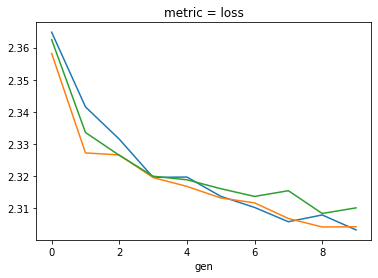

In [277]:
for seed in range(3):
    fitdata.sel(seed=seed, metric='loss').mean(dim='pop').plot()

In [28]:
import xarray as xr

In [96]:
a = xr.DataArray(np.random.randn(100, 3), dims=('pop', 'metric'), coords={'metric': ['loss', 'fitness', 'accuracy']})
b = xr.DataArray(np.random.randn(100, 3), dims=('pop', 'metric'), coords={'metric': ['loss', 'fitness', 'accuracy']})

In [132]:
class Neuroevolution(ga.SimpleGA):
    def __init__(self):
        super().__init__()
        
        self.calc_npop = partial(ga.calc_npop_tournament, 
                                 k_elite=3, k_tournament=5, do_crossover=True,
                                 calc_clone_fn=self.calc_clone,
                                 calc_mutate_fn=self.calc_mutate,
                                 calc_crossover_fn=self.calc_crossover, )
        
        self.pop_evol = {}
        
    def ask(self):
        if self.gen_idx>1:
            if self.gen_idx<10 or self.gen_idx%30==0:
                self.pop_evol[self.gen_idx] = self.pop
        return super().ask()
    
    def calc_ipop(self):
        return [genotype.Genotype.generate_random(pheno_class=pheno_class, pheno=pheno,
                                                  breeder_class=breeder_class, breeder=breeder,
                                                  mutator_class=mutator_class, mutator=mutator, device=device) 
                for _ in range(50)]
    def calc_clone(self, xs):
        return xs
    def calc_mutate(self, xs):
        return [a.mutate() for a in xs]
    def calc_crossover(self, xs1, xs2):
        return [a.crossover(b) for a,b in zip(xs1, xs2)]


In [147]:
seed = 400
n_gens = 100

torch.manual_seed(seed); np.random.seed(seed)
pheno_class = models_pheno.SmallNet
pheno = pheno_class().to(device)
breeder_class = models_breed.UniformBreeder
# breeder_class = partial(models_breed.ConvRSBProbBreeder, breeder_init_zeros=True)
breeder = breeder_class().to(device)
mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=False)
# mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=True)
mutator = mutator_class().to(device)
ne = Neuroevolution()
ne.run_evolution(n_gens, calc_fitdata_fn=partial(task.calc_pop_fitness, n_samples=500, device=device), tqdm=tqdm)
ne_base = ne

torch.manual_seed(seed); np.random.seed(seed)
pheno_class = models_pheno.SmallNet
pheno = pheno_class().to(device)
breeder_class = models_breed.UniformBreeder
# breeder_class = partial(models_breed.ConvRSBProbBreeder, breeder_init_zeros=True)
breeder = breeder_class().to(device)
# mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=False)
# mutator_class = partial(models_mutate.AGMutator, eps=1e-2, shape=[130], adaptive_eps=True)
mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=True)
# mutator_class = partial(models_mutate.ConvMutator)
mutator = mutator_class().to(device)
ne = Neuroevolution()
ne.run_evolution(n_gens, calc_fitdata_fn=partial(task.calc_pop_fitness, n_samples=500, device=device), tqdm=tqdm)
ne_ae = ne

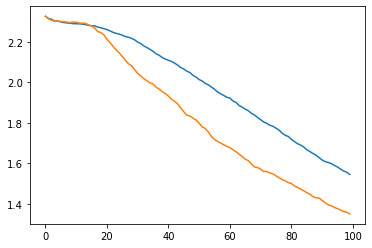

In [148]:
plt.plot(ne_base.fitdata.mean(axis=-1)['loss'])
plt.plot(ne_ae.fitdata.mean(axis=-1)['loss'])

In [204]:
n_gens = 100

nes = []
nes_new = []
for delta in [1e-3, 2e-3, 4e-3, 8e-3]:
    for seed in tqdm(range(10)):
        torch.manual_seed(seed); np.random.seed(seed)
        pheno_class = models_pheno.SmallNet
        pheno = pheno_class().to(device)
        breeder_class = models_breed.UniformBreeder
        breeder = breeder_class().to(device)
        mutator_class = partial(models_mutate.AGMutator, eps=1e-2, adaptive_eps=True, delta=delta)
        mutator = mutator_class().to(device)
        ne = Neuroevolution()
        ne.run_evolution(n_gens, calc_fitdata_fn=partial(task.calc_pop_fitness, n_samples=500, device=device), tqdm=tqdm, leave=False)
        nes.append(ne)


In [215]:
fd = MultiArr.stack([ne.fitdata for ne in nes])
fd=fd.reshape((4, 10, 100, 50))
# fd2 = MultiArr.stack([ne.fitdata for ne in nes_new])

In [225]:
fd.shape

(4, 10, 100, 50)

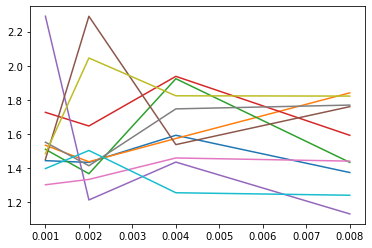

In [222]:
plt.plot([1e-3, 2e-3, 4e-3, 8e-3],fd.mean(axis=(3))[:, :, -1]['loss'])
# plt.plot(fd.mean(axis=3).std(1)[:, -1]['loss'])

(4, 10, 100)


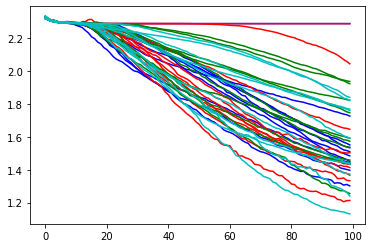

In [208]:
print(fd.shape)
for f, c in zip(fd, ['b', 'r', 'g', 'c']):
    for fi in f:
        plt.plot(fi['loss'], c=c)


In [160]:
print(fd.mean(axis=(0,2))[-1]['loss'])
print(fd2.mean(axis=(0,2))[-1]['loss'])

1.5051796426773072
1.5212110483646393


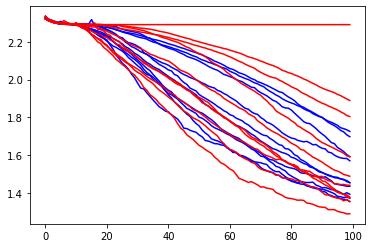

In [164]:
for f in fd.mean(axis=-1):
    plt.plot(f['loss'], c='b')
for f in fd2.mean(axis=-1):
    plt.plot(f['loss'], c='r')

# plt.errorbar(x=np.arange(100), 
#              y=fd.mean(axis=(0, 2))['loss'],
#              yerr=fd.std(axis=(0, 2))['loss'])
# plt.errorbar(x=np.arange(100), 
#              y=fd2.mean(axis=(0, 2))['loss'],
#              yerr=fd2.std(axis=(0, 2))['loss'])

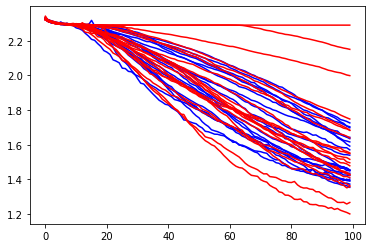

In [131]:
for f in fd.mean(axis=-1):
    plt.plot(f['loss'], c='b')
for f in fd2.mean(axis=-1):
    plt.plot(f['loss'], c='r')

# plt.errorbar(x=np.arange(100), 
#              y=fd.mean(axis=(0, 2))['loss'],
#              yerr=fd.std(axis=(0, 2))['loss'])
# plt.errorbar(x=np.arange(100), 
#              y=fd2.mean(axis=(0, 2))['loss'],
#              yerr=fd2.std(axis=(0, 2))['loss'])

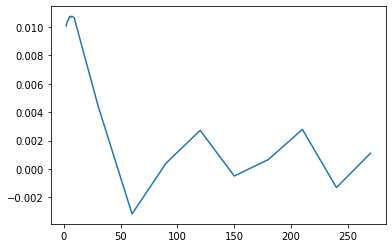

In [84]:
a = np.array(list(ne_ae.pop_evol.values()))
a = np.array(list(map(lambda x: x.mutator_weights.detach().cpu().numpy().mean(), a.flatten())))
a = a.reshape(-1,50)
plt.plot(list(ne_ae.pop_evol.keys()), a.mean(axis=-1))

(11, 50, 130)


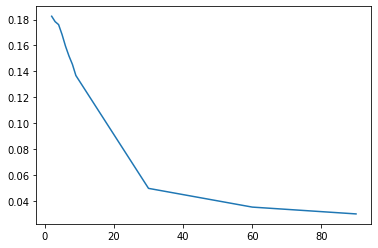

In [62]:
gens = ne.pop_evol.keys()
weights = np.array([[geno.pheno_weights.detach().cpu().numpy() for geno in pop_gen] 
          for gen_idx, pop_gen in ne.pop_evol.items()])
print(weights.shape)
plt.plot(gens, weights.std(axis=1).mean(axis=-1))

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390])


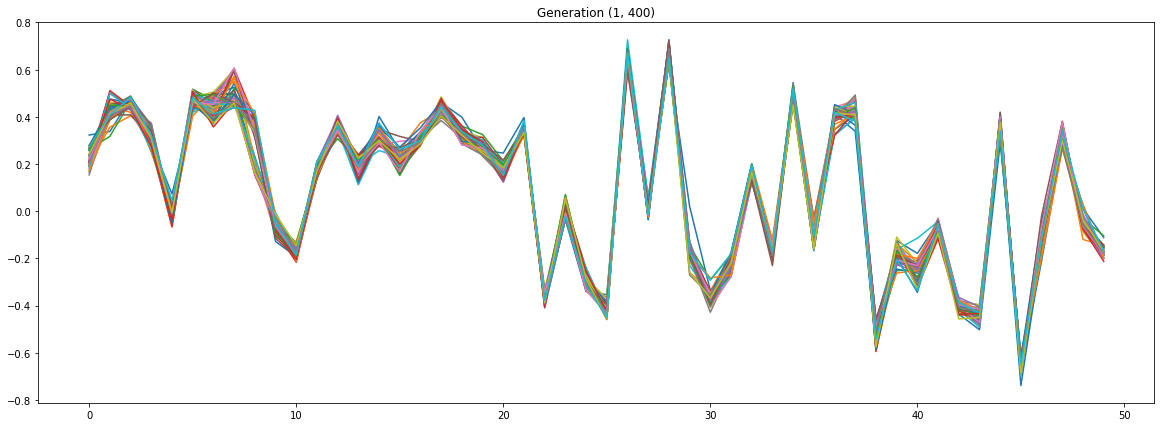

0.02923328


In [45]:
print(ne.pop_evol.keys())
gen_idx = 390
w = np.array([geno.pheno_weights.detach().cpu().numpy() for geno in ne.pop_evol[gen_idx]])
plt.figure(figsize=(20,7))
plt.plot(w[:, :50].T)
plt.title(f'Generation {key}')
plt.show()
print(w.std(axis=0).mean())

(-0.04, 0.04)

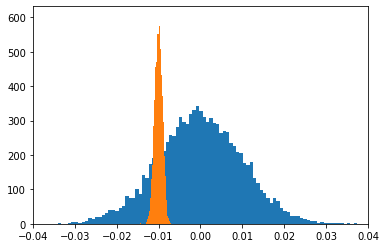

In [67]:
plt.hist(1e-2*np.random.randn(10000), bins=100);
plt.hist(models_mutate.ConvMutator().mutate(torch.randn(10300)).detach().cpu().numpy(), bins=100);
plt.xlim(-4e-2, 4e-2)

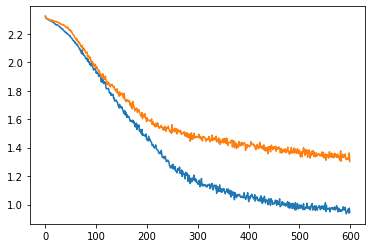

In [113]:
plt.plot(util.arr_dict2dict_arr(util.arr_dict_mean(np.array(ne_base.fitdata_evol), axis=-1))['loss'])
plt.plot(util.arr_dict2dict_arr(util.arr_dict_mean(np.array(ne_ae.fitdata_evol), axis=-1))['loss'])

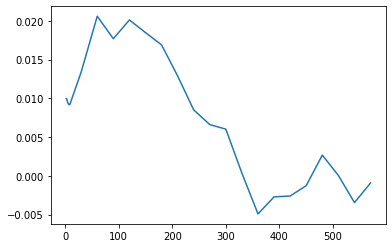

In [122]:
a = np.array(list(ne_ae.pop_evol.values()))
a = np.array(list(map(lambda x: x.mutator_weights.detach().cpu().numpy(), a.flatten()))).reshape(27,100)
plt.plot(list(ne_ae.pop_evol.keys()), a.mean(axis=-1))

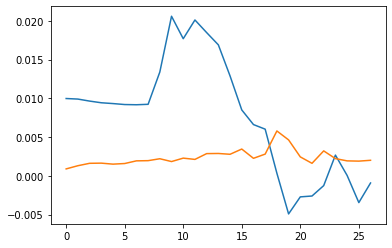

In [110]:
plt.plot(a.mean(axis=-1));
plt.plot(a.std(axis=-1));

In [239]:
weights = np.array([[geno.pheno_weights.detach().cpu().numpy() for geno in pop_gen] for pop_gen in ne.pop_evol.values()])
weights.shape

(17, 100, 130)

In [240]:
X = weights.reshape(-1, weights.shape[-1])
# Xp = TSNE(n_components=2).fit_transform(X)
Xp = PCA(n_components=2).fit_transform(X)
Xp = Xp.reshape(*weights.shape[:2], 2)
Xp.shape

(17, 100, 2)

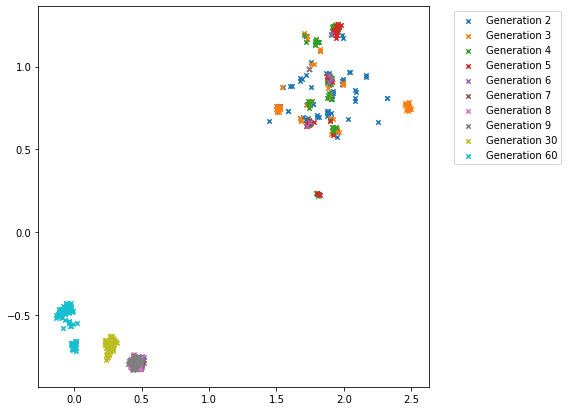

In [241]:
plt.figure(figsize=(7, 7))
for i, Xpi in enumerate(Xp[:10]):
    plt.scatter(*Xpi.T, s=20, marker='x', label=f'Generation {list(ne.pop_evol.keys())[i]}')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [177]:
from sklearn.manifold import TSNE
X = np.random.randn(1000, 3000)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1000, 2)

In [238]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [272]:
fitdata_gens = cmaes.run_cmaes(models_pheno.SmallNet, task.calc_pheo_fitness, 300, 30, device, tqdm)

(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 130 (seed=964664, Wed Jun 16 16:53:26 2021)


In [10]:
torch.load('data/mnist_sgd_eval')

{models_pheno.SmallNet: {'fitness': -0.6912355422973633,
  'loss': 0.6912355422973633,
  'accuracy': 78.32249999999999},
 models_pheno.ConvNet: {'fitness': -0.28138837218284607,
  'loss': 0.28138837218284607,
  'accuracy': 91.6425},
 models_pheno.BigConvNet: {'fitness': -0.10598196089267731,
  'loss': 0.10598196089267731,
  'accuracy': 96.65}}